# Import 

In [2]:
# Import torch
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

## Setup device agnostic

In [3]:
# TODO: Setup device agnostic code
from argparse import ArgumentParser

parser = ArgumentParser(description="computer vision model argument")
parser.add_argument("--disable-cuda",  type=bool, default=False, help="Choose cuda device to train model?")
parser.add_argument("--learning-rate", "-lr", type=float, default=.01, help="Learning rate")
parser.add_argument("--epochs", "-e", type=int, default=40, help="Epochs")
parser.add_argument("--MODEL-PATH", type=str, default="../../Module/models", help="Model save path")
parser.add_argument('--file', '-f', type=str)
args = parser.parse_args()

args.device = None
if not args.disable_cuda and torch.cuda.is_available():
    args.device = "cuda"
else:
    args.device = 'cpu'

## Download Dataset

In [4]:
import os
import zipfile
import requests
from pathlib import Path


url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} has already been downloaded...")
else:
    print(f"Folder {image_path} wasn't founded. Creating one...")
    
    image_path.mkdir(parents=True, exist_ok=True)
    
    with open(image_path / "pizza_steak_sushi.zip", "wb") as f:
        print("Downloading pizza_steak_sushi.zip...")
        response = requests.get(url)
        f.write(response.content)
        
    with zipfile.ZipFile(image_path / "pizza_steak_sushi.zip") as zip_file:
        print(f"Extracting file...")
        zip_file.extractall(image_path)
        
    print(f"Downloaded Successfully")

data\pizza_steak_sushi has already been downloaded...


## Data Exploding

### Explode shape, Visualize Image

In [5]:
def walk_through_path(folder_path):
    for root, dirs, files in os.walk(folder_path):
        print(f"There are {len(dirs)} directories and {len(files)} files in {root}")
        
walk_through_path(image_path)

There are 2 directories and 1 files in data\pizza_steak_sushi
There are 3 directories and 0 files in data\pizza_steak_sushi\test
There are 0 directories and 25 files in data\pizza_steak_sushi\test\pizza
There are 0 directories and 19 files in data\pizza_steak_sushi\test\steak
There are 0 directories and 31 files in data\pizza_steak_sushi\test\sushi
There are 3 directories and 0 files in data\pizza_steak_sushi\train
There are 0 directories and 78 files in data\pizza_steak_sushi\train\pizza
There are 0 directories and 75 files in data\pizza_steak_sushi\train\steak
There are 0 directories and 72 files in data\pizza_steak_sushi\train\sushi


In [6]:
list(image_path.glob("*/*/*.jpg"))

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2218680.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/309892.jp

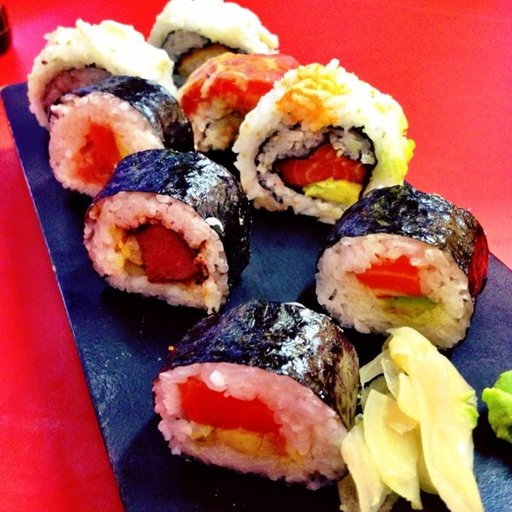

In [7]:
from PIL import Image

Image.open(list(image_path.glob("*/*/*.jpg"))[50])

### Get random image and visualize

1. Get all of the image paths using `pathlib.Path.glob()` to find all of the files ending in .jpg.
2. Pick a random image path using Python's `random.choice()`.
3. Get the image class name using `pathlib.Path.parent.stem`.
4. And since we're working with images, we'll open the random image path using `PIL.Image.open()` (`PIL` stands for **Python Image Library**).
5. We'll then show the image and print some metadata.

Class name image: sushi
Root directory: data\pizza_steak_sushi\train\sushi\773725.jpg
Width x Height: 382 x 512


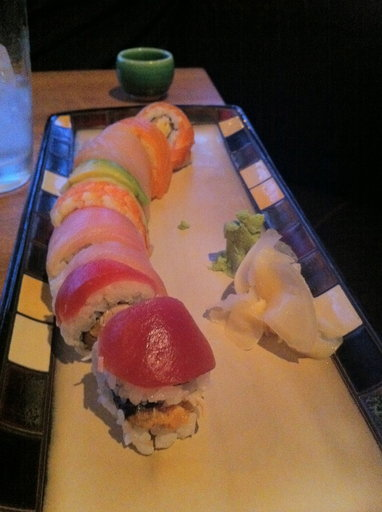

In [8]:
import random
from PIL import Image

random.seed(10)

# Get all image path in every dir and convert it to list
image_list = list(image_path.glob("*/*/*.jpg"))

# Get random image
random_image = random.choice(image_list)

# Get class name
class_random_image = random_image.parent.stem

img = Image.open(random_image)

# Print
print(f"Class name image: {class_random_image}")
print(f"Root directory: {random_image}")
print(f"Width x Height: {img.width} x {img.height}")
img

## 3. Transforming data
Now what if we wanted to load our image data into **PyTorch**?

Before we can use our image data with PyTorch we need to:

- Turn it into tensors (numerical representations of our images).
- Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these Dataset and *DataLoader* for short.
- There are several different kinds of pre-built datasets and dataset loaders for **PyTorch**, depending on the problem you're working on.

### 3.1 Transforming data with torchvision.transforms
We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the torchvision.transforms module.

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes .

To get experience with `torchvision.transforms`, let's write a series of transform steps that:

 - Resize the images using `transforms.Resize()` (from about *512x512* to *64x64*, the same shape as the images on the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/)).
 - Flip our images randomly on the horizontal using `transforms.RandomHorizontalFlip()` (this could be considered a form of data augmentation because it will artificially change our image data).
 - Turn our images from a `PIL` image to a PyTorch tensor using `transforms.ToTensor()`.
 - We can compile all of these steps using `torchvision.transforms.Compose()`.

In [9]:
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torchvision.transforms import RandomHorizontalFlip
from torchvision.transforms import ToTensor

data_transforms = Compose([
    Resize(size=(64, 64)),
    RandomHorizontalFlip(p=.7),
    ToTensor()
])

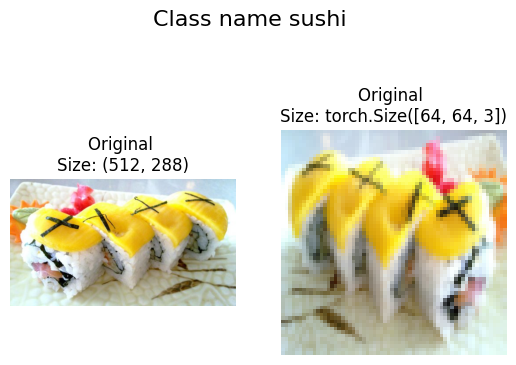

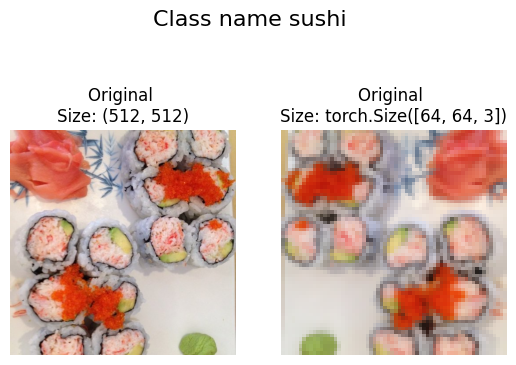

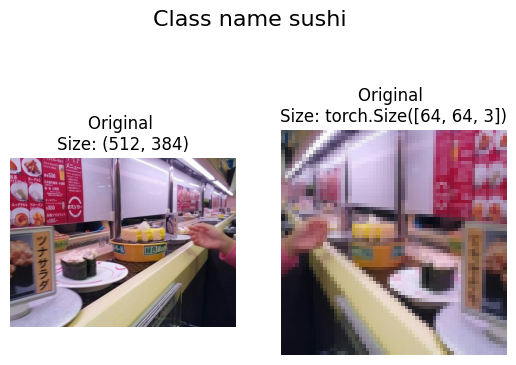

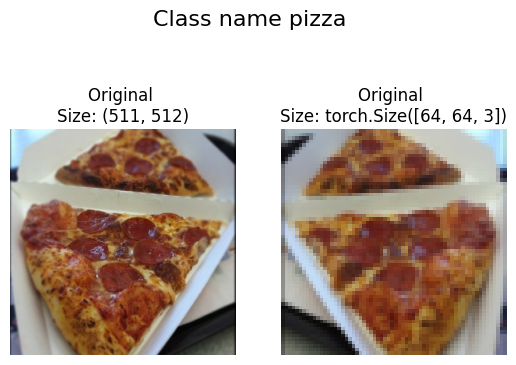

In [10]:
random.seed(82)

def plot_transform_image(image_paths, transforms, n=4):
    """
    Plot transform random n images
    Print class name and size
    
    Arg:
        - image_paths: path to dataset, this must be Path instance
        - transforms: data transform pipeline
        - n: number of image that will be ploted
    """
    image_list = list(image_paths.glob("*/*/*.jpg"))
    image_random_choice = random.sample(list(image_list), k=n)
    for idx, image_path in enumerate(image_random_choice):
        with Image.open(image_path) as img:
            fig, (ax1, ax2) = plt.subplots(1, 2)
            ax1.imshow(img)
            ax1.set_title(f"Original \nSize: {img.size}")
            ax1.axis(False)
            
            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transforms(img).permute(1, 2, 0)
            ax2.imshow(transformed_image)
            ax2.set_title(f"Original \nSize: {transformed_image.shape}")
            ax2.axis(False)
            
            fig.suptitle(f"Class name {image_path.parent.stem}", fontsize=16)
    
    
plot_transform_image(image_path, data_transforms)


### 4. Turn loaded images into `DataLoader`'s

In [11]:
from torch.utils.data import DataLoader

train_transform = Compose([
    Resize(size=(64, 64)),
    RandomHorizontalFlip(p=.7),
    ToTensor()
])

test_transform = Compose([
    Resize(size=(64, 64)),
    ToTensor()
])

In [12]:
from torchvision.datasets import ImageFolder

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dataset = ImageFolder(root=train_dir,
                            transform=train_transform,
                            target_transform=None)


test_dataset = ImageFolder(root=test_dir,
            transform=test_transform,
            target_transform=None)


In [28]:
os.cpu_count()

12

In [29]:
batch_size = 1
num_workers = 2

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=batch_size,
                              num_workers=num_workers,
                              shuffle=False)




In [30]:
train_dataset.class_to_idx, train_dataset.classes

({'pizza': 0, 'steak': 1, 'sushi': 2}, ['pizza', 'steak', 'sushi'])

In [31]:
class_names = train_dataset.classes
class_names

['pizza', 'steak', 'sushi']

Shape torch.Size([1, 3, 64, 64]) -> [batch_size, color_channel, width, height] 
Class pizza


(-0.5, 63.5, 63.5, -0.5)

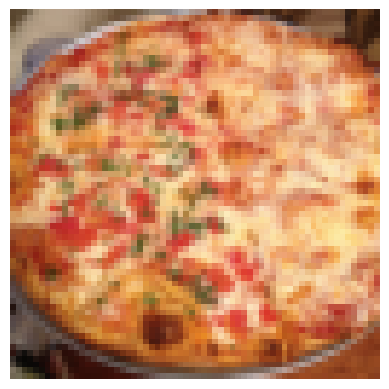

In [32]:
image, label = next(iter(train_dataloader))

print(f"Shape {image.shape} -> [batch_size, color_channel, width, height] \nClass {class_names[label]}")
plt.imshow(image.squeeze().permute(1, 2, 0))
plt.axis("off")

## Loading Image Data with a Custom Dataset

To see this in action, let's work towards replicating `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset` (the base class for all Dataset's in PyTorch).

We'll start by importing the modules we need:

- Python's `os` for dealing with directories (our data is stored in directories).
- Python's `pathlib` for dealing with filepaths (each of our images has a unique filepath).
- `torch` for all things PyTorch.
- `PIL`'s Image class for loading images.
- `torch.utils.data.Dataset` to subclass and create our own custom Dataset.
- `torchvision.transforms` to turn our images into tensors.
- Various types from Python's `typing` module to add type hints to our code.
> Note: You can customize the following steps for your own dataset. The premise remains: write code to load your data in the format you'd like it.

In [17]:
import os
import pathlib
import torch

from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, List, Dict

### Create helper function to get class names

Let's write a helper function capable of creating a list of class names and a dictionary of class names and their indexes given a directory path.

To do so, we'll:

- Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
- Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
- Turn the class names into a dictionary of numerical labels, one for each class.

Let's see a small example of step 1 before we write the full function.

In [18]:
target_directory = train_dir
print(f"Target dir {target_directory}")

Target dir data\pizza_steak_sushi\train


In [19]:
for row in os.scandir(target_directory): 
    print(row.name)

pizza
steak
sushi


In [39]:
def scan_class_names(directory: str) -> Tuple[List[str], Dict[str, int]]:
    class_names = sorted([ dirs.name for dirs in os.scandir(directory) if dirs.is_dir() ])
    
    if not class_names:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}")
        
    class_to_idx = {classes: i for i, classes in enumerate(class_names)}
        
    return class_names, class_to_idx

In [40]:
class_names, class_to_idx = scan_class_names(target_directory)

In [41]:
class_names, class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [45]:
class CustomDataset(Dataset):
    
    def __init__(self, root: str, transform=None) -> None:
        
        self.paths = list(pathlib.Path(root).glob("*/*.jpg"))
        
        self.transform = transform
        
        self.classes, self.class_to_idx = scan_class_names(root)
        
    def __len__(self) -> int:
        return len(self.paths)
    
    def load_image(self, index: int) -> Image.Image:
        img_path = self.paths[index]
        return Image.open(img_path)
    
    def __getitem__(self, index: int) -> Tuple[Image.Image, int]:
        
        image_load = self.load_image(index)
        class_names = self.paths[index].parent.stem
        class_idx = self.class_to_idx[class_names]
        
        if self.transform:
            return self.transform(image_load), class_idx
        return image_load, class_idx

In [46]:
train_customdataset = CustomDataset(root=train_dir,
                                    transform=train_transform)

test_customdataset = CustomDataset(root=test_dir,
                                    transform=test_transform)

pizza


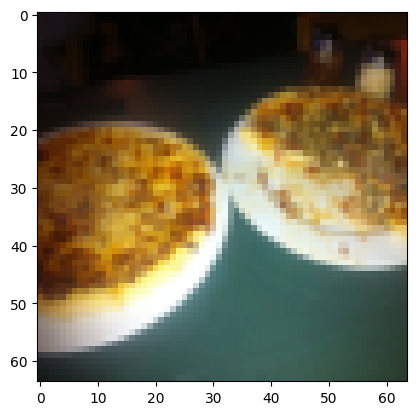

In [47]:
img, label = train_customdataset[0]
print(class_names[label])
plt.imshow(img.squeeze().permute(1, 2, 0));

In [61]:
len(train_customdataset), len(test_customdataset)

(225, 75)

In [53]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_customdataset) == len(train_dataset)) & (len(test_customdataset) == len(test_dataset)))
print(train_customdataset.classes == train_dataset.classes)
print(train_customdataset.class_to_idx == train_dataset.class_to_idx)

True
True
True


In [66]:
len(test_customdataset)
sorted(list(test_customdataset), key=lambda x: x[1])

[(tensor([[[0.0471, 0.2039, 0.3725,  ..., 0.0824, 0.1333, 0.1020],
           [0.2000, 0.1961, 0.2667,  ..., 0.0784, 0.1255, 0.1137],
           [0.0980, 0.1176, 0.1333,  ..., 0.1059, 0.1255, 0.1255],
           ...,
           [0.0196, 0.0196, 0.0235,  ..., 0.0863, 0.1059, 0.0980],
           [0.0196, 0.0235, 0.0235,  ..., 0.0863, 0.1020, 0.0941],
           [0.0196, 0.0196, 0.0235,  ..., 0.0980, 0.0980, 0.0863]],
  
          [[0.0196, 0.1255, 0.2471,  ..., 0.0235, 0.0353, 0.0235],
           [0.1333, 0.1216, 0.1608,  ..., 0.0157, 0.0275, 0.0235],
           [0.0588, 0.0667, 0.0784,  ..., 0.0314, 0.0196, 0.0235],
           ...,
           [0.0039, 0.0039, 0.0078,  ..., 0.0196, 0.0235, 0.0196],
           [0.0039, 0.0078, 0.0078,  ..., 0.0196, 0.0235, 0.0196],
           [0.0039, 0.0039, 0.0078,  ..., 0.0314, 0.0235, 0.0196]],
  
          [[0.0118, 0.0392, 0.0588,  ..., 0.0039, 0.0078, 0.0039],
           [0.0510, 0.0314, 0.0431,  ..., 0.0039, 0.0078, 0.0039],
           [0.0275, 0.

In [84]:
def visualize_random_image_customdataset(dataset : Dataset,
                                         n : int = 4,
                                         seed: int = 82):
    random.seed(seed)
    size = len(dataset)
    plt.figure(figsize=(12, 6))
    for idx in range(n):
        ranint = random.randint(0, size)
        image, label = dataset[ranint]
        
        plt.subplot( (n // 4) + 1 , 4, idx + 1)
        plt.imshow(image.squeeze().permute(1, 2, 0))
        plt.title(class_names[label])
        plt.axis(False)
        
    plt.show()


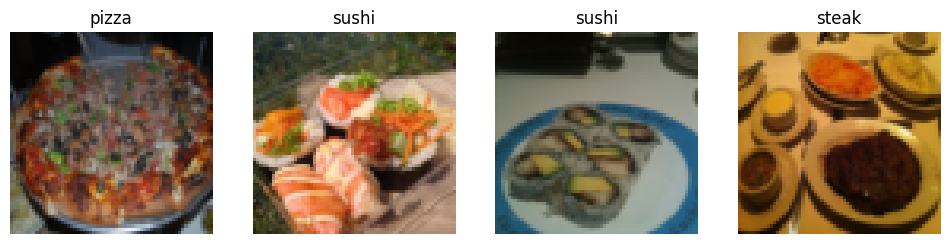

In [85]:
visualize_random_image_customdataset(test_customdataset)

In [90]:
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torchvision.transforms import TrivialAugmentWide
from torchvision.transforms import ToTensor

train_transforms = Compose([
    Resize(size=(256, 256)),
    TrivialAugmentWide(num_magnitude_bins=31),
    ToTensor()
])

test_transforms = Compose([
    Resize(size=(256, 256)),
    ToTensor()
])

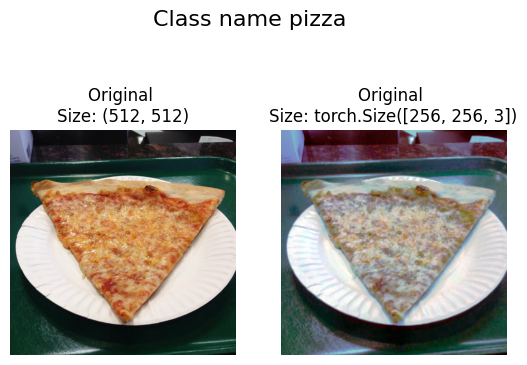

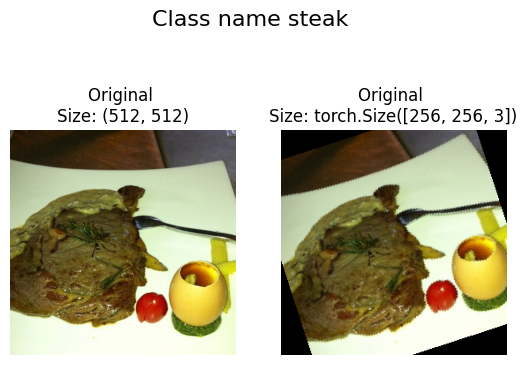

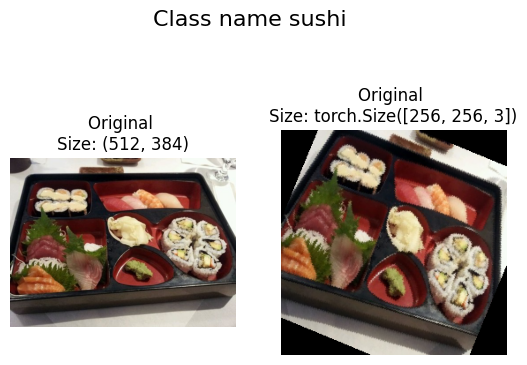

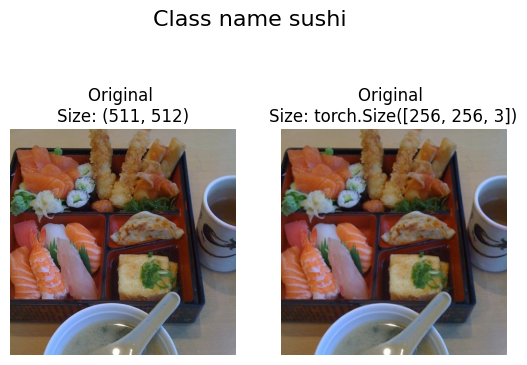

In [92]:
plot_transform_image(image_path, train_transforms)

## Model TinyVGG without data augment

In [93]:
simple_transform = Compose([
    Resize(size=(64, 64)),
    ToTensor()
])

In [95]:
test_dir

WindowsPath('data/pizza_steak_sushi/test')

In [96]:
train_simple_dataset = ImageFolder(root=train_dir,
                                   transform=simple_transform,
                                   target_transform=None)

test_simple_dataset = ImageFolder(root=test_dir,
                                   transform=simple_transform,
                                   target_transform=None)

train_simple_dataset, test_simple_dataset

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [97]:
batch_size = 32
num_workers = 8

train_simple_dataloader = DataLoader(dataset=train_simple_dataset,
                           batch_size=batch_size,
                           num_workers=num_workers,
                           shuffle=True)

test_simple_dataloader = DataLoader(dataset=test_simple_dataset, 
                                    batch_size=batch_size,
                                    num_workers=num_workers,
                                    shuffle=False)


train_simple_dataloader, test_simple_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1941a38f910>,
 <torch.utils.data.dataloader.DataLoader at 0x1941a497940>)

In [117]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding='same'), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x) 
        # print(x.shape)
        x = self.conv_block_2(x) 
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_simple_dataset.classes)).to(args.device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [118]:
image, label = next(iter(train_simple_dataloader))

print(f"Size input image: {image.shape}")

with torch.inference_mode():
    infer_res = model_0(image.type(torch.float).to(args.device))

    
print(f"Size output result: {infer_res.shape}")

Size input image: torch.Size([32, 3, 64, 64])
Size output result: torch.Size([32, 3])


In [119]:
try:
    from torchinfo import summary
except:
    !pip install -q torchinfo
    from torchinfo import summary
    
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [120]:
def train_step():
    
    

In [121]:
def test_step():
    pass
